# **Portfolio Optimisation**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [ ]:
tickers = ["ASIANPAINT.NS","SBIN.NS","TATAMOTORS.NS"]

In [ ]:
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)
print(start_date)

2014-07-02 10:01:37.344889


**Adjusted Close Price**

In [ ]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    adj_close_df[ticker] = yf.download(ticker, start=start_date, end=end_date, interval="1d")["Adj Close"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(adj_close_df)

            ASIANPAINT.NS     SBIN.NS  TATAMOTORS.NS
Date                                                
2014-07-02     541.891357  245.698563     446.090973
2014-07-03     539.710999  245.148514     459.743866
2014-07-04     546.159363  245.321228     459.450256
2014-07-07     550.751953  244.102875     468.649963
2014-07-08     547.504700  234.146729     459.988495
...                   ...         ...            ...
2024-06-24    2896.050049  832.700012     958.049988
2024-06-25    2858.449951  842.250000     955.000000
2024-06-26    2863.350098  845.349976     951.849976
2024-06-27    2880.850098  844.000000     972.099976
2024-06-28    2917.050049  848.950012     989.750000

[2461 rows x 3 columns]


Lognormal returns


In [ ]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns.dropna(inplace=True)

**Variance-Covariance Matrix**

In [ ]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

               ASIANPAINT.NS   SBIN.NS  TATAMOTORS.NS
ASIANPAINT.NS       0.064917  0.022189       0.027438
SBIN.NS             0.022189  0.114441       0.061389
TATAMOTORS.NS       0.027438  0.061389       0.173486


Standard Deviation

In [ ]:
def std_dev(weights, cov_matrix):
  variance = np.dot(weights.T, np.dot(cov_matrix, weights))
  std = np.sqrt(variance)
  return std

Expected Returns

In [ ]:
def expected_returns(weights, log_returns):
  expected_return = np.sum(log_returns.mean() * weights)*252
  return expected_return

Sharpe Ratio

In [ ]:
def calc_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  expected_return = expected_returns(weights, log_returns)
  std = std_dev(weights, cov_matrix)
  sharpe_ratio = (expected_return - risk_free_rate) / std
  return sharpe_ratio

In [ ]:
risk_free_rate = 7.14/100    # Risk free rate is taken as India 10 year bond yiels from investing.com

In [ ]:
def negative_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  sharpe_ratio = calc_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)
  return -sharpe_ratio

In [ ]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

In [ ]:
initial_weights = [0.4,0.3,0.3]

In [ ]:
optimized_weights = minimize(negative_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

In [ ]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimized_weights.x):
    print(f"{ticker}: {weight:.2f}")

print()

print("Expected Return:", expected_returns(optimized_weights.x, log_returns))
print("Standard Deviation:", std_dev(optimized_weights.x, cov_matrix))
print("Sharpe Ratio:", calc_sharpe_ratio(optimized_weights.x, log_returns, cov_matrix, risk_free_rate))

Optimal Weights:
ASIANPAINT.NS: 0.88
SBIN.NS: 0.12
TATAMOTORS.NS: 0.00

Expected Return: 0.1671003664089412
Standard Deviation: 0.2382139827729939
Sharpe Ratio: 0.40174117948457666


## **Value at Risk**

In [ ]:
portfolio_value = 100000

In [ ]:
def random_z_score():
  return np.random.normal(0,1)

In [ ]:
def var_percent(weights, log_returns, cov_matrix, z_score):
  expected_return = expected_returns(weights, log_returns)
  std = std_dev(weights, cov_matrix)
  z_score = random_z_score()
  var = expected_return + (std * z_score)
  return var

Monte Carlo Simulations

In [36]:
simulations = 10000
scenarios = [0.0]*10000

for i in range(simulations):
  z_score = random_z_score()
  scenarios[i] = (var_percent(optimized_weights.x, log_returns, cov_matrix, z_score))

In [37]:
confidence = 0.95
per = 1 - confidence
var_per = np.percentile(scenarios,100*per)
print("Value at Risk (95% Confidence):", var_per)

Value at Risk (95% Confidence): -0.22709803768769674


In [33]:
var_inr = var_per * portfolio_value
print("Value at Risk (INR):", var_inr)

Value at Risk (INR): -22488.388705186902


In [34]:
final_value = portfolio_value + var_inr
print("Final Portfolio Value:", final_value)

Final Portfolio Value: 77511.6112948131


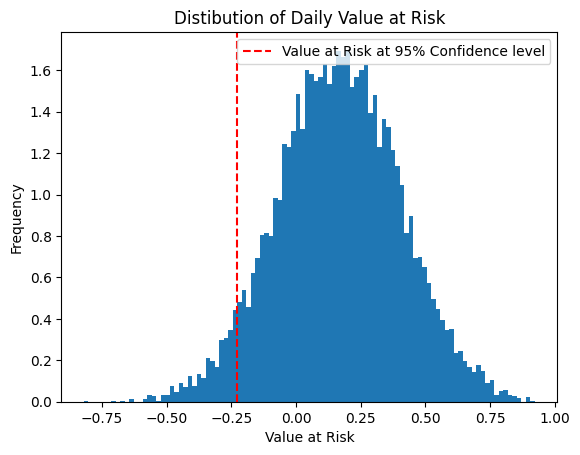

In [38]:
plt.hist(scenarios,bins = 100, density = True)
plt.xlabel('Value at Risk')
plt.ylabel('Frequency')
plt.title('Distibution of Daily Value at Risk')
plt.axvline(x=var_per,color = 'red', linestyle = '--', label = 'Value at Risk at 95% Confidence level')
plt.legend()
plt.show()